# Qualitative results using full pipeline

In [1]:
import sys
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.patches as patches
import seaborn as sns
from torch.utils.data import DataLoader

sys.path.insert(0, os.path.abspath('..'))

from src.utils.load_cfg import ConfigLoader
from src.factories import ModelFactory
from src.factories import DatasetFactory
from src.utils.misc import MiscUtils
from src.models.pytorch_ssim.ssim import SSIM

%matplotlib inline
sns.set_style('whitegrid', {'axes.grid': False})


#--------------------------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_cfg = '../configs/dataset_cfgs/epickitchens_short.yaml'
train_cfg = '../configs/train_cfgs/train_san_freeze_short.yaml'
model_cfg = '../configs/model_cfgs/pipeline8_rgbspec_san19pairfreeze_halluconv2_actreggru2_timernn_top3_cat.yaml'
model_weight = '/home/knmac/Dropbox/SparseSensing/DGX_training_logs/finetune_pipeline8_top3_eff0.01_nofc1_1024hid_2lay/best.model'

In [2]:
#--------------------------------------------------------------------------------------
# Load configurations
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
# model_params['num_segments'] = 25
dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(dataset_cfg)
train_params = ConfigLoader.load_train_cfg(train_cfg)

dataset_params.update({
    'modality': model_params['modality'],
    'num_segments': model_params['num_segments'],
    'new_length': model_params['new_length'],
})

for k in ['low_feat_model_cfg', 'high_feat_model_cfg', 'hallu_model_cfg',
          'actreg_model_cfg', 'spatial_sampler_cfg', 'temporal_sampler_cfg',
          'hallu_pretrained_weights', 'actreg_pretrained_weights']:
    model_params[k] = '../'+model_params[k]

#--------------------------------------------------------------------------------------
# Build model
model_factory = ModelFactory()
model = model_factory.generate(model_name, device=device, model_factory=model_factory, **model_params)
model = model.to(device)
model.load_model(model_weight)
model.eval()

#--------------------------------------------------------------------------------------
# Get training augmentation and transforms
train_augmentation = MiscUtils.get_train_augmentation(model.modality, model.crop_size)
train_transform, val_transform = MiscUtils.get_train_val_transforms(
    modality=model.modality,
    input_mean=model.input_mean,
    input_std=model.input_std,
    scale_size=model.scale_size,
    crop_size=model.crop_size,
    train_augmentation=train_augmentation,
)

#--------------------------------------------------------------------------------------
# Data loader
dataset_factory = DatasetFactory()
loader_params = {
    'batch_size': train_params['batch_size'],
    'num_workers': train_params['num_workers'],
    'pin_memory': True,
}

val_dataset = dataset_factory.generate(dataset_name, mode='val', transform=val_transform, **dataset_params)
val_loader = DataLoader(val_dataset, shuffle=False, **loader_params)

In [3]:
def run_experiment(sample_id):
    model.temperature = 0.5

    with torch.no_grad():
        # Get a sample
        sample, _ = val_loader.dataset[sample_id]
        sample = {k: v.unsqueeze(dim=0).to(device) for k, v in sample.items()}

        # Forward
        output, loss_eff, gflops = model(sample)

        # Extract intermediate data, replicate the sampling process
        attn = model._pivot_mod_fn.get_attention_weight(
            l_name=model.attention_layer[0],
            m_name=model.attention_layer[1],
            aggregated=True,
        )

        vmin = attn.mean(dim=1).min()
        vmax = attn.mean(dim=1).max()
        hallu_mem = None
        hallu = torch.zeros_like(attn)
        bboxes = [None for _ in range(model.num_segments)]

        model.spatial_sampler.reset()
        model.temporal_sampler.reset()
        last_attn = attn[0]
        for t in range(model.num_segments):
            if t>0 and gflops[0][t] in [model.gflops_prescan, model.gflops_full]:
                hallu[t], hallu_mem = model.hallu_model(last_attn.unsqueeze(dim=0).unsqueeze(dim=0), hallu_mem)
                vmin = min(vmin, hallu[t].mean(dim=0).min())
                vmax = max(vmax, hallu[t].mean(dim=0).max())
                last_attn = attn[t]

            if gflops[0][t] == model.gflops_full:
                bboxes[t] = model.spatial_sampler.sample_frame(attn[t].unsqueeze(dim=0), 224, reorder=True)


    attn = attn.cpu().detach().numpy()
    hallu = hallu.cpu().detach().numpy()

    # Visualize
    rgb = MiscUtils.deprocess_rgb(sample['RGB'][0], model.num_segments)
    fig, axes = plt.subplots(4, model.num_segments, figsize=(20, 8))

    for ax in axes.ravel():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

    for t in range(model.num_segments):
        axes[0, t].imshow(rgb[t])
        if gflops[0][t] in [model.gflops_prescan, model.gflops_full]:
            axes[1, t].imshow(attn.mean(axis=1)[t], vmin=vmin, vmax=vmax)
            if t>0:
                axes[2, t].imshow(hallu.mean(axis=1)[t], vmin=vmin, vmax=vmax)
        if gflops[0][t] == model.gflops_full:
            tmp = np.zeros_like(rgb[t]) + 255
            for k in range(model.spatial_sampler.top_k):
                top, left, bottom, right = bboxes[t][0, k]
                tmp[top:bottom, left:right] = rgb[t][top:bottom, left:right]
            axes[3, t].imshow(tmp)

        if gflops[0][t] == model.gflops_prescan:
            axes[0, t].axis('on')
            for spine in axes[0, t].spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(10)
        if gflops[0][t] == model.gflops_full:
            axes[0, t].axis('on')
            for spine in axes[0, t].spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(10)

    print(gflops[0].cpu().numpy())

[6.76303078 0.54717073 0.54717073 0.         0.         0.
 0.54717073 6.76303078 0.54717073 6.76303078]


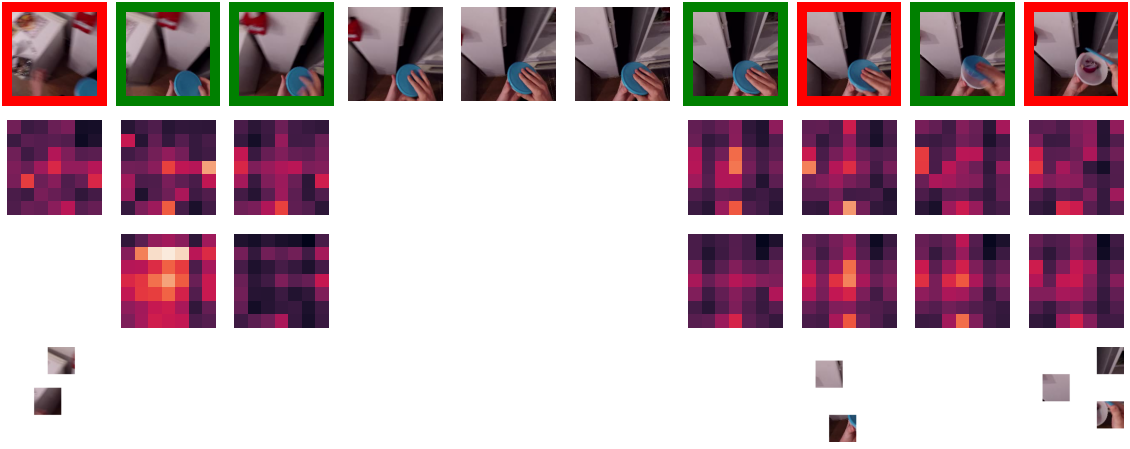

In [74]:
run_experiment(sample_id=3)

[6.76303078 0.54717073 0.         0.54717073 0.         0.
 0.         0.54717073 0.         6.76303078]


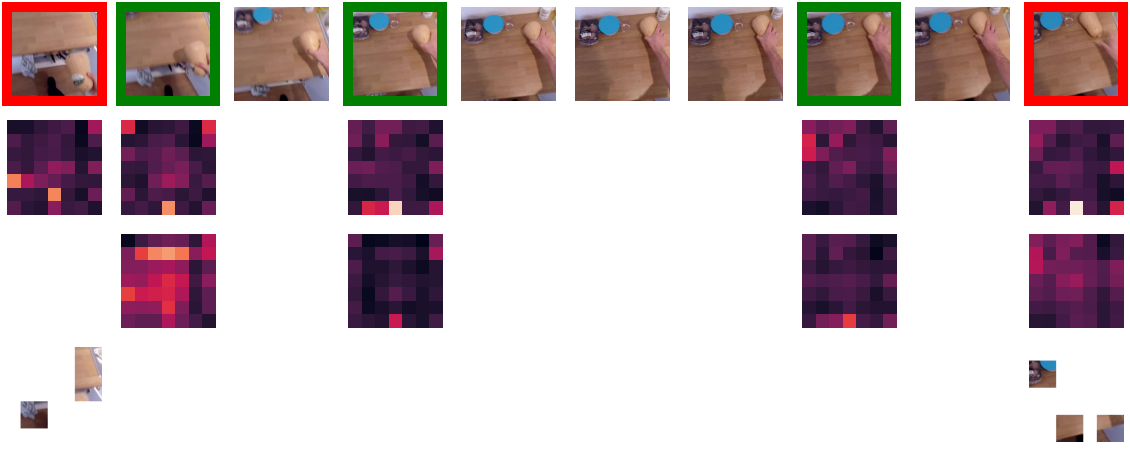

In [44]:
run_experiment(sample_id=17)

[6.76303078 6.76303078 0.54717073 0.         0.         0.
 6.76303078 0.54717073 0.         0.        ]


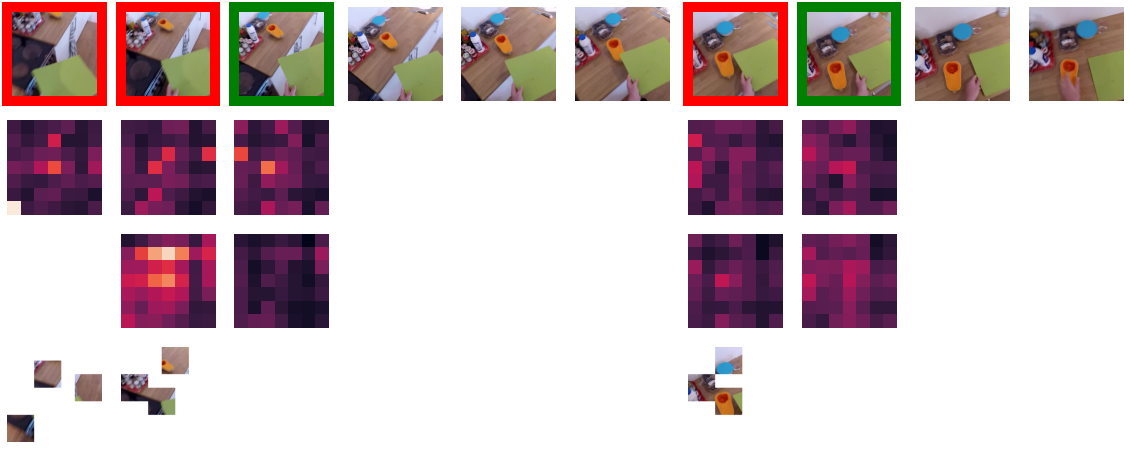

In [10]:
run_experiment(sample_id=57)

[6.76303078 0.54717073 0.         0.         0.54717073 0.
 0.         0.54717073 0.         0.        ]


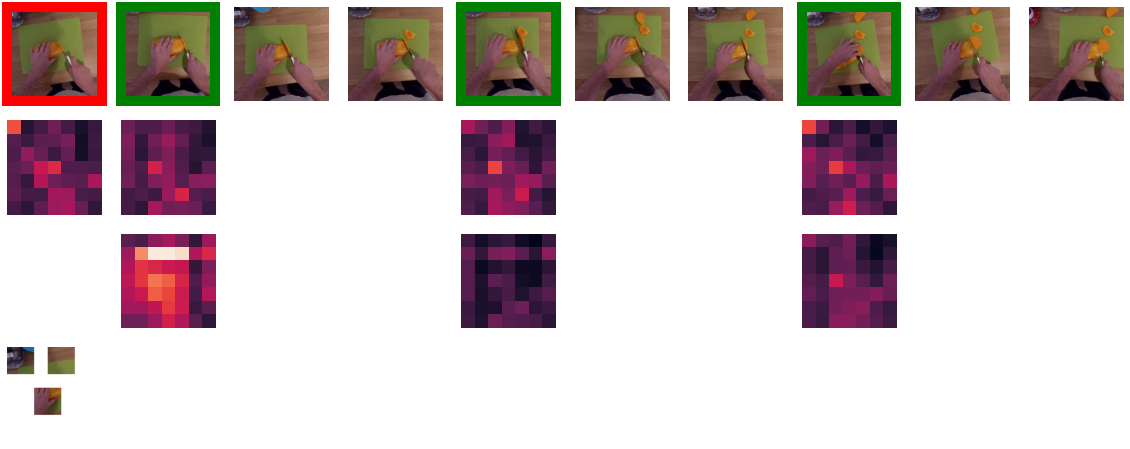

In [76]:
run_experiment(sample_id=87)